In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import yaml

In [18]:
## some styling 

plt.style.use('dark_background')

# colors
red    = '#f54242'
orange = '#f7993b'
yellow = '#ffe359'
green  = '#a2f781'
blue   = '#42daf5'
purple = '#d170fa'

# change boxplot
mpl.rcParams['boxplot.boxprops.color'] = blue
mpl.rcParams['boxplot.boxprops.linewidth'] = 1

mpl.rcParams['boxplot.whiskerprops.color'] = blue
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 1

mpl.rcParams['boxplot.medianprops.color'] = blue
mpl.rcParams['boxplot.medianprops.linewidth'] = 1

mpl.rcParams['boxplot.capprops.color'] = blue
mpl.rcParams['boxplot.capprops.linewidth'] = 1

mpl.rcParams['boxplot.flierprops.markeredgecolor'] = red

## 1. Loading the data

In [8]:
with open('./eda_config.yaml') as infile:
    config = yaml.safe_load(infile)

In [9]:
df = pd.read_csv(config['rad_data'], sep=';')
df = df[df['TRANSTEXT'].notna()]
df['AANKSDATUM'] = pd.to_datetime(df['AANKSDATUM'])
df['AANGEMAAKT'] = pd.to_datetime(df['AANGEMAAKT'])

In [10]:
# print(df[df['BESTEMMING'] == 'OPN'].iloc[1]['TRANSTEXT'])

In [11]:
invalid_codes = ['NHTA', # Naar huis tegen advies
                'MOR',  # Mortuarium / overleden
                'OVNH'] # Overleden naar huis

admission_codes = ['OPN', # Opname
                 'OVER']  # Overplaatsing ander ziekenhuis

df = df[~df['BESTEMMING'].isin(invalid_codes)]

df.loc[df['BESTEMMING'].isin(admission_codes), 'BESTEMMING']  = 1
df.loc[df['BESTEMMING']!=1, 'BESTEMMING'] = 0

## 2. EDA

In [12]:
def create_date_histogram(df, n_bins=50):

    colors = [blue, red]

    plt.figure(figsize=(13, 7))
    plt.title('Distribution of the dates')
    plt.xlabel('Year')
    plt.ylabel('Number of lab results')

    bottom = 0
    range = (pd.to_datetime('20150101'), 
             pd.to_datetime('20230901'))

    for i, categorie in enumerate(df['BESTEMMING'].unique()):
        subset = df[df['BESTEMMING'] == i]['AANKSDATUM']
        hist_values, bins, _ = plt.hist(subset, bins=n_bins, color=colors[i], range=range, width=40, label=categorie, bottom=bottom)
        bottom = hist_values  # start value, so that it is stacked next time

    combined_subset = df['AANKSDATUM']
    combined_hist_values, combined_bins, _ = plt.hist(combined_subset, bins=n_bins, range=range, color='gray', alpha=0, width=40)

    # Calculate the centers of the bins
    bin_centers = (combined_bins[:-1] + combined_bins[1:]) / 2

    # Fit a linear regression line to the combined histogram values
    z = np.polyfit(bin_centers, combined_hist_values, 1)
    p = np.poly1d(z)

    # Plot the combined trendline
    plt.plot(bin_centers, p(bin_centers), color='white', linestyle='dashed', label='Combined Trendline')

    plt.gcf().autofmt_xdate()
    plt.ylim(0, max(combined_hist_values * 1.2))
    plt.xlim(*range)
    plt.grid(alpha=.2)
    plt.legend(labels=['Trendline', 'Not admitted', 'Admitted'], loc='best')
    plt.show()

def merge_datetime(date_col, time_col):
    date_col = pd.to_datetime(date_col).astype(str)
    return pd.to_datetime(date_col + ' ' + time_col, format='%Y-%m-%d %H:%M:%S')

In [13]:
df['BESTEMMING'].value_counts()

1    43008
0    26015
Name: BESTEMMING, dtype: int64

In [14]:
df.isna().sum()

SEHID            0
PATIENTNR        0
AANKSDATUM       0
AANKSTIJD        1
AANGEMAAKT       0
AANMTIJD         0
ACCDATUM       178
ACCTIJD        178
INDICATIE     4783
TRANSTEXT        0
BESTEMMING       0
dtype: int64

In [15]:
df = df[df['ACCDATUM'].notna()]

In [16]:
df = df[df['AANKSTIJD'].notna()]

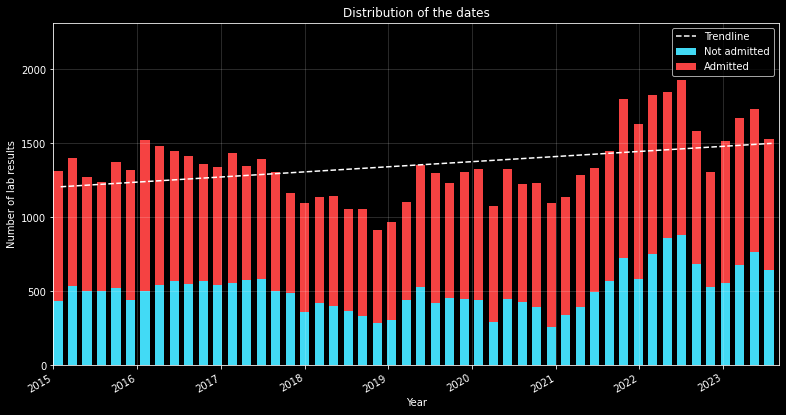

In [19]:
create_date_histogram(df)

In [20]:
df['TIMEDELTA'] = merge_datetime(df['ACCDATUM'], df['ACCTIJD']) - merge_datetime(df['AANKSDATUM'], df['AANKSTIJD'])
df['HOURDELTA'] = df['TIMEDELTA'].apply(lambda x: x.total_seconds() / 60 / 60)

In [21]:
df['HOURDELTA'].mean()

15.15099645575504

In [22]:
df['HOURDELTA'].median()

14.7

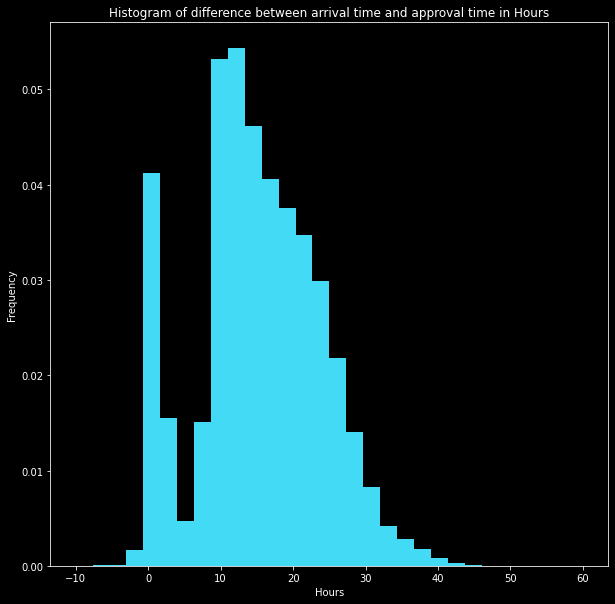

In [24]:
plt.figure(figsize=(10, 10))
plt.hist(df['HOURDELTA'], color=blue, density=True, range=(-10, 60), bins=30)
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title('Histogram of difference between arrival time and approval time in Hours')
plt.show()

## 3. Machine Learning (test)

In [25]:
from transformers import DistilBertTokenizerFast


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/pyenvs/admission-prediction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [26]:
from datasets import Dataset

dset = Dataset.from_pandas(df)
dsets = dset.train_test_split(test_size=0.15, seed=42)
dsets_clean = dsets["train"].train_test_split(test_size=0.30, seed=42)
dsets_clean["validation"] = dsets_clean.pop("test")
dsets_clean["test"] = dsets["test"]

In [8]:
from datasets import ClassLabel

# We take our categorical labels and wrap them in a class that easily converts back and forth between numerical representation and text
label_names = [0, 1]
labels = ClassLabel(names=label_names)
labels

ClassLabel(num_classes=2, names=[0, 1], id=None)

In [9]:
def preprocess(batch):
    
    tokens = tokenizer(batch['TRANSTEXT'], truncation=True, max_length=128)  
    tokens['label'] = labels.str2int(batch['BESTEMMING'])
    
    return tokens

In [10]:
tokenized_dsets = dsets_clean.map(preprocess, batched=True)
# tokenized_dsets

100%|██████████| 11/11 [00:01<00:00,  8.17ba/s]


DatasetDict({
    train: Dataset({
        features: ['SEHID', 'PATIENTNR', 'AANKSDATUM', 'AANKSTIJD', 'AANGEMAAKT', 'AANMTIJD', 'INDICATIE', 'TRANSTEXT', 'BESTEMMING', '__index_level_0__', 'input_ids', 'attention_mask', 'label'],
        num_rows: 41020
    })
    validation: Dataset({
        features: ['SEHID', 'PATIENTNR', 'AANKSDATUM', 'AANKSTIJD', 'AANGEMAAKT', 'AANMTIJD', 'INDICATIE', 'TRANSTEXT', 'BESTEMMING', '__index_level_0__', 'input_ids', 'attention_mask', 'label'],
        num_rows: 17581
    })
    test: Dataset({
        features: ['SEHID', 'PATIENTNR', 'AANKSDATUM', 'AANKSTIJD', 'AANGEMAAKT', 'AANMTIJD', 'INDICATIE', 'TRANSTEXT', 'BESTEMMING', '__index_level_0__', 'input_ids', 'attention_mask', 'label'],
        num_rows: 10342
    })
})

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.special import softmax

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    probabilities = softmax(logits, axis=1)  # Compute probabilities using softmax
    predictions = np.argmax(logits, axis=1)  # Compute predicted labels
    auc_score = roc_auc_score(labels, probabilities[:, 1])  # Calculate AUC for the positive class
    
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_score": f1_score(labels, predictions),
        # "probabilities": probabilities.tolist(),
        "auc": auc_score  # Add AUC score to the output
    }


# This step configures our training experiment
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    fp16=True
)

# Now we select our model and train it
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dsets['train'],
    eval_dataset=tokenized_dsets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_output = trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /export/home/jmaathuis/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_p

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Auc
1,0.502700,0.465828,0.790228,0.843370,0.844851
2,0.480900,0.448467,0.799556,0.847128,0.855004
3,0.413400,0.461010,0.803993,0.847495,0.857400
4,0.329900,0.509547,0.806609,0.853474,0.853388
5,0.201000,0.552415,0.799556,0.844867,0.847061


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke

In [18]:
test_output = trainer.predict(tokenized_dsets['test'])
print(test_output.metrics)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, PATIENTNR, SEHID, AANKSDATUM, BESTEMMING, TRANSTEXT, INDICATIE, AANKSTIJD, AANGEMAAKT, AANMTIJD. If __index_level_0__, PATIENTNR, SEHID, AANKSDATUM, BESTEMMING, TRANSTEXT, INDICATIE, AANKSTIJD, AANGEMAAKT, AANMTIJD are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10342
  Batch size = 64


{'test_loss': 0.5426986813545227, 'test_accuracy': 0.8002320634306711, 'test_f1_score': 0.8433899332929049, 'test_auc': 0.8554649537325815, 'test_runtime': 8.6009, 'test_samples_per_second': 1202.435, 'test_steps_per_second': 18.835}
